# Init Colab:
> *make sure that you have selected the **correct** branch*


In [18]:
%%capture
# This only runs in colab and clones the code sets it up and fixes a few issues,
# you can skip this if you are running Jupyter Notebooks
import sys
if "google.colab" in sys.modules:
    branch = "grace_dev"    # change to the branch you want
    ! git clone --single-branch --branch $branch https://github.com/godormad/PySyft.git
    ! cd PySyft && ./scripts/colab.sh      # fixes some colab python issues
    sys.path.append("/content/PySyft/src") # prevents needing restart

# Setup - Connect to a Remote Duet Server
All modules are imported here, make sure everything is installed by running the cell below.

In [2]:
import syft as sy
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as vutils
from torch.utils.data import DataLoader

##### Paste the code or Server ID that the Data Owner gives you and run it in the cell below. It will return your Client ID which you must send to the Data Owner to enter into Duet so it can pair your notebooks.

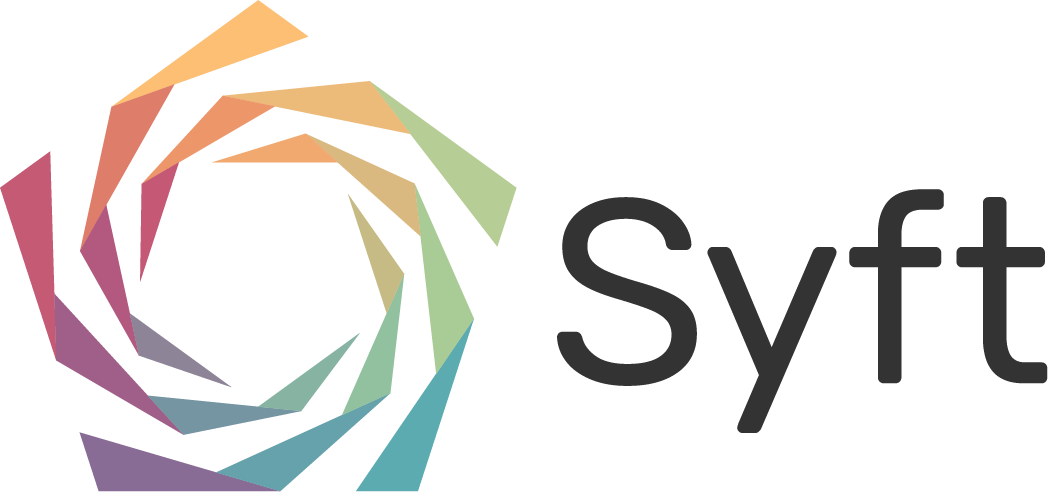

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ >             Use at your own risk.

♫♫♫ > 
♫♫♫ >
♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... DONE!

♫♫♫ > Duet Client ID: df06bc7abf4871837fa6f238e9b6382d

♫♫♫ > STEP 1: Send the Duet Client ID to your duet partner!

♫♫♫ > ...waiting for partner to connect...
♫♫♫ > ...using a running event loop...

♫♫♫ > CONNECTED!


In [3]:
duet = sy.join_duet("d38d6a210cafb403b5f194c3a07933c1")

## Checkpoint 1 : Now STOP and run the Data Owner notebook until Checkpoint 2


### Load Data

> We request access to the training data based on tags



In [4]:
 duet.store.pandas

ID         Tags Description
0  <UID: 7d2a17d7896c41cd82ff9b1c9414533d>     [inputs]            
1  <UID: 82e1efed1307439a8389034c3cd5764e>    [targets]            
2  <UID: 2446785663974c4bb27ea8187c3b7504>  [train_len]

In [5]:
inputs = duet.store["inputs"]
targets = duet.store["targets"]
train_len = duet.store["train_len"]

Custom dataset to process tensorpointers 


In [6]:
class DatasetFromPointer(data.Dataset):
    def __init__(self,
                 inputs_tensorpointer,
                 targets_tensorpointer,
                 trainlen,
                 ):
        super(DatasetFromPointer, self).__init__()
        self.inputs_tensorpointer = inputs_tensorpointer
        self.targets_tensorpointer = targets_tensorpointer
        self.trainlen = trainlen

    def __getitem__(self, index):
        input = self.inputs_tensorpointer[index]
        target = self.targets_tensorpointer[index]
        return input, target

    def __len__(self):
        return self.trainlen
def batch_idx_fn(batch):
    return batch[0]

In [7]:
train_len

Request dataset size. Only get the size of training data.

In [8]:
train_len = train_len.get(request_block=True,
        reason="To write the training loop",
        timeout_secs=120,
        delete_obj=False,
    )

Check that the length is retrieved correctly

In [9]:
train_len

tensor(60000)

Initialize dataset using data pointers (no direct access to raw data) ! advanced scenario should encypt pointer too


In [10]:
train_set = DatasetFromPointer(inputs, targets, train_len)
training_data_loader = DataLoader(dataset=train_set,
                                  num_workers=0, batch_size=1, shuffle=True,collate_fn=batch_idx_fn)

### Define the Model

In [11]:
class Net(sy.Module):
    def __init__(self, torch_ref):
        super(Net, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = self.torch_ref.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = self.torch_ref.nn.Dropout2d(0.25)
        self.dropout2 = self.torch_ref.nn.Dropout2d(0.5)
        self.fc1 = self.torch_ref.nn.Linear(9216, 128)
        self.fc2 = self.torch_ref.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.torch_ref.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.torch_ref.flatten(x, 1)
        x = self.fc1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = self.torch_ref.nn.functional.log_softmax(x, dim=1)
        return output


In [12]:
remote_torch = duet.torch

Send local model to duet store 

In [13]:
local_net = Net(torch)
remote_net = local_net.send(duet)

> Creating local model
> Sending local model
> Creating remote model
  Sending local layer: conv1
  Sending local layer: conv2
  Sending local layer: dropout1
  Sending local layer: dropout2
  Sending local layer: fc1
  Sending local layer: fc2

> Finished sending local model <




In [14]:
criterion = remote_torch.nn.MSELoss()
optimizer = remote_torch.optim.Adam(remote_net.parameters(), lr=0.001)

### Training

In [ ]:
for epoch in range(10):
    
    remote_net.train()
    epoch_loss = 0
    for batch_idx, data_pointers in enumerate(training_data_loader):

        optimizer.zero_grad()
        input_ptr, target_ptr = data_pointers[0], data_pointers[1]
        #input's shape should be [batch,channel,H,W]
        input_ptr_reshape = remote_torch.unsqueeze(remote_torch.unsqueeze(input_ptr, 0), 0)
        #output's shape should be [batch,int]
        target_ptr_reshape = remote_torch.unsqueeze(target_ptr, 0)
       
        output_ptr = remote_net(input_ptr_reshape)
        
        loss = criterion(output_ptr, target_ptr_reshape)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            loss_item = loss.item().get(
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=120,
                delete_obj=False,
                verbose=False
                )
            print(f"epoch {epoch}, batch_idx {batch_idx}, loss {loss_item}")


epoch 0, batch_idx 0, loss 10.936781883239746
epoch 0, batch_idx 100, loss 10.939112663269043
epoch 0, batch_idx 200, loss 5.348966598510742
